In [1]:
# 读取数据
import numpy as np
import pandas as pd

rankdata_000 = pd.read_csv(
    r'D:\Study\Python\Workspace\rainbowSixSiege_analysis\datadump_s5_ranked_data\datadump_s5-000.csv')

In [2]:
# 初步筛选
data = rankdata_000.loc[:,
       ['matchid', 'roundnumber', 'gamemode', 'mapname', 'roundduration', 'skillrank', 'role', 'haswon', 'operator']]
# 筛选进攻or防守方
data = data.loc[data['role'] == 'Attacker']

In [3]:
# 干员转换哑变量
opdata = pd.get_dummies(data['operator'], drop_first=False, prefix='OP')
newdata = pd.merge(data, opdata, left_index=True, right_index=True)
new_matchid = newdata['matchid'].map(str) + "_" + newdata['roundnumber'].map(str) + "_" + newdata['role'].map(str)
newdata = newdata.drop(labels=['matchid', 'roundnumber', 'role'], axis=1)
newdata.insert(0, 'newmatchid', new_matchid, allow_duplicates=False)
newdata.head()

,newmatchid,gamemode,mapname,roundduration,skillrank,haswon,operator,OP_BOPE-CAPITAO,OP_G.E.O.-JACKAL,OP_GIGN-MONTAGNE,...,OP_SAS-RESERVE,OP_SAS-SLEDGE,OP_SAS-THATCHER,OP_SAT-HIBANA,OP_SPETSNAZ-FUZE,OP_SPETSNAZ-GLAZ,OP_SPETSNAZ-RESERVE,OP_SWAT-ASH,OP_SWAT-RESERVE,OP_SWAT-THERMITE
6,1522380841_5_Attacker,HOSTAGE,CLUB_HOUSE,175,Gold,1,G.E.O.-JACKAL,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,1522380841_1_Attacker,HOSTAGE,CLUB_HOUSE,124,Gold,0,GIGN-TWITCH,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1522380841_6_Attacker,HOSTAGE,CLUB_HOUSE,143,Gold,1,SWAT-ASH,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10,1522380841_2_Attacker,HOSTAGE,CLUB_HOUSE,129,Gold,1,SWAT-ASH,0,0,0,...,0,0,0,0,0,0,0,1,0,0
13,1522380841_5_Attacker,HOSTAGE,CLUB_HOUSE,175,Gold,1,JTF2-BUCK,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# 数据数值化、离散化
newdata['gamemode'] = newdata['gamemode'].replace({'HOSTAGE': 1, 'BOMB': 2, 'SECURE_AREA': 3})
newdata['mapname'] = newdata['mapname'].replace(
    {'CLUB_HOUSE': 1, 'PLANE': 2, 'KANAL': 3, 'HEREFORD_BASE': 4, 'CONSULATE': 5,
     'YACHT': 6, 'OREGON': 7, 'BORDER': 8, 'SKYSCRAPER': 9, 'BANK': 10, 'COASTLINE': 11,
     'BARTLETT_U.': 12, 'HOUSE': 13, 'KAFE_DOSTOYEVSKY': 14, 'FAVELAS': 15, 'CHALET': 16})
newdata['skillrank'] = newdata['skillrank'].replace(
    {'Gold': 4, 'Unranked': 0, 'Platinum': 5, 'Silver': 3, 'Bronze': 1, 'Copper': 2, 'Diamond': 4})

In [5]:
# 个人数据转为对局数据
print(newdata.shape)
newdata_cp = newdata.copy()
# 利用对局时间筛选无效数据
newdata_cp = newdata_cp.loc[(newdata_cp['roundduration'] >= 90) & (newdata_cp['roundduration'] <= 210)]
res = newdata_cp.groupby(newdata_cp['newmatchid']).agg({max}).reset_index()
print(res.shape)

(1996117, 27)
(276137, 27)


In [6]:
# 转换为numpy训练矩阵
SCALE = res.shape[0]
label = np.array(res.loc[:SCALE - 1, :]['haswon'])
print(label.shape)
train_data = np.array(
    res.drop(labels=['newmatchid', 'haswon', 'gamemode', 'mapname', 'roundduration', 'skillrank', 'operator'], axis=1).loc[:SCALE - 1, :])
print(train_data.shape)

(276137, 1)
(276137, 20)


C:\Users\Think\.conda\envs\pytorch_gpu\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


{'C': 17, 'kernel': 'linear'}
[SVM]AUC Score: 0.577041
[SVM]Report: 
               precision    recall  f1-score   support

           0       0.59      0.35      0.44       108
           1       0.62      0.82      0.71       142

    accuracy                           0.62       250
   macro avg       0.61      0.58      0.57       250
weighted avg       0.61      0.62      0.59       250



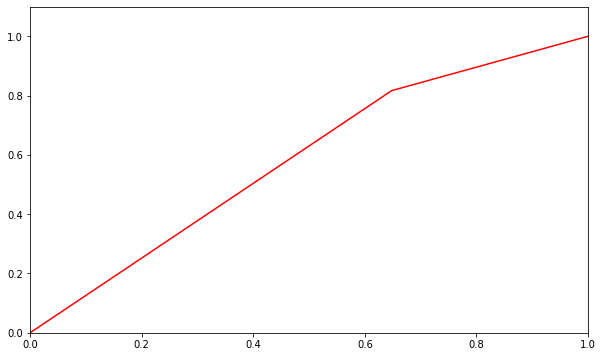

In [22]:
# SVM with sklearn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, metrics

# prepare data
c = np.column_stack((train_data, label))  # 将y添加到x的最后一列
np.random.shuffle(c)
shuffled_data = c[:1000, :-1]  # 乱序后的x
shuffled_label = c[:1000, -1]  # 同等乱序后的y
x_train, x_test, y_train, y_test = train_test_split(shuffled_data, shuffled_label, random_state=1, train_size=0.75)

estimator = svm.SVC(probability=True)
parameters = [
	{
		'C': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
	    'gamma': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000],
	    'kernel': ['rbf']
	},
	{
		'C': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
	    'kernel': ['linear']
	}
]
svm = GridSearchCV(estimator, parameters, cv=5, n_jobs=8)
svm.fit(x_train, y_train)
print(svm.best_params_)
best_model = svm.best_estimator_
y_pre = best_model.predict(x_test)

svm_predprob = best_model.predict_proba(x_test)[:, 1]
print("[SVM]AUC Score: %f" % metrics.roc_auc_score(y_test, svm_predprob, multi_class='ovo'))
print("[SVM]Report: \n", metrics.classification_report(y_test, y_pre))

fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, y_pre)
plt.figure(figsize=(10, 6))
plt.xlim(0, 1)
plt.ylim(0.0, 1.1)
plt.plot(fpr1, tpr1, color='red')
plt.show()

Best parameters found by grid search are: {'learning_rate': 1, 'n_estimators': 20}
Feature importances: [28, 45, 33, 10, 34, 24, 26, 22, 33, 36, 17, 37, 29, 37, 40, 29, 12, 50, 14, 44]
AUC Score: 0.592587
Report: 
               precision    recall  f1-score   support

           0       0.58      0.21      0.31     27860
           1       0.63      0.90      0.74     41175

    accuracy                           0.62     69035
   macro avg       0.60      0.55      0.52     69035
weighted avg       0.61      0.62      0.57     69035



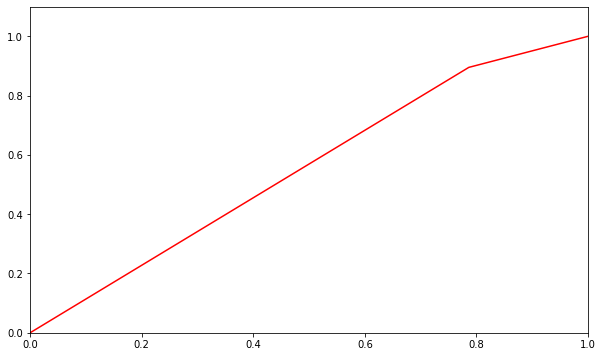

In [30]:
# Lightgbm
from lightgbm import LGBMClassifier

# prepare data
c = np.column_stack((train_data, label))  # 将y添加到x的最后一列
np.random.shuffle(c)
shuffled_data = c[:, :-1]  # 乱序后的x
shuffled_label = c[:, -1]  # 同等乱序后的y
x_train, x_test, y_train, y_test = train_test_split(shuffled_data, shuffled_label, random_state=1, train_size=0.75)

estimator = LGBMClassifier(num_leaves=31)
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [10, 20, 40]
}
gbm = GridSearchCV(estimator, param_grid)
gbm.fit(x_train, y_train)
print('Best parameters found by grid search are:', gbm.best_params_)
# 模型预测
best_model = gbm.best_estimator_
y_pre = best_model.predict(x_test, num_iteration=best_model.best_iteration_)
# 特征重要度
print('Feature importances:', list(best_model.feature_importances_))

gbm_predprob = best_model.predict_proba(x_test)[:, 1]
print("AUC Score: %f" % metrics.roc_auc_score(y_test, gbm_predprob, multi_class='ovo'))
print("Report: \n", metrics.classification_report(y_test, y_pre))

fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, y_pre)
plt.figure(figsize=(10, 6))
plt.xlim(0, 1)
plt.ylim(0.0, 1.1)
plt.plot(fpr2, tpr2, color='red')
plt.show()

Using cuda device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=2, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 0.714021  [    0/207102]
loss: 0.708613  [ 2560/207102]
loss: 0.703425  [ 5120/207102]
loss: 0.702997  [ 7680/207102]
loss: 0.696039  [10240/207102]
loss: 0.695344  [12800/207102]
loss: 0.695239  [15360/207102]
loss: 0.693715  [17920/207102]
loss: 0.689637  [20480/207102]
loss: 0.687725  [23040/207102]
loss: 0.686703  [25600/207102]
loss: 0.687679  [28160/207102]
loss: 0.688080  [30720/207102]
loss: 0.682811  [33280/207102]
loss: 0.682237  [35840/207102]
loss: 0.687085  [38400/207102]
loss: 0.672761  [40960/207102]
loss: 0.683360  [43520/207102]
loss: 0.679486  [46080/207102]
loss: 0.684281  [48640/207102]
loss: 0.669407  [51200/207102]
loss: 0.666550  [53760/2

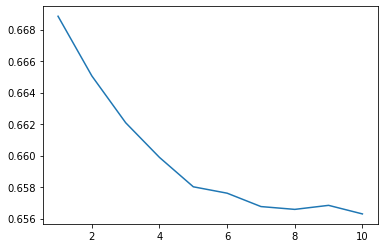

In [31]:
# MLP with PyTorch
import time
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt


# choose device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

# prepare data
c = np.column_stack((train_data, label))  # 将y添加到x的最后一列
np.random.shuffle(c)
shuffled_data = c[:, :-1]  # 乱序后的x
shuffled_label = c[:, -1]  # 同等乱序后的y
SIZE = int(SCALE * 0.75)
train_x = shuffled_data[:SIZE]
test_x = shuffled_data[SIZE:]
y = []
for n in range(label.shape[0]):
    if label[n] == 0:
        y.append((1, 0))
    else:
        y.append((1, 0))
train_y = np.array(shuffled_label[:SIZE])
test_y = np.array(shuffled_label[SIZE:])


class CustomDataset(Dataset):
    def __init__(self, train):
        if train:
            self.data = torch.from_numpy(train_x.astype('float32')).to(torch.device(device))
            self.labels = torch.from_numpy(train_y).to(torch.device(device))
        else:
            self.data = torch.from_numpy(test_x.astype('float32')).to(torch.device(device))
            self.labels = torch.from_numpy(test_y).to(torch.device(device))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        d = self.data[idx]
        l = self.labels[idx]
        return d, l


learning_rate = 1e-4
batch_size = 256
epochs = 10
input_dim = train_data.shape[1]
output_dim = label.shape[1]

train_dataset = CustomDataset(train=True)
test_dataset = CustomDataset(train=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, output_dim + 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss


model = NeuralNetwork().to(torch.device(device))
print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

test = []
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    test.append(test_loss)
print("Done! Running time: " + str(time.time() - start_time))
plt.plot(np.array(list(range(1, epochs + 1))), np.array(test))
plt.show()